In [1]:
import sys
sys.path.insert(0, '..//src')

import global_func as gf
import data_preprocessing as dp
import predict
import model_fitting as mf

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 

config_dir = '..\\config\\'
data_proc_dir = '..\\' + gf.read_config(config_dir=config_dir, section='DIR', key='DATA_PROCESSED')
models_dir = '..\\' + gf.read_config(config_dir=config_dir, section='DIR', key='MODELS')
data_remod_dir = '..\\' + gf.read_config(config_dir=config_dir, section='DIR', key='DATA_REMODEL')

# Modelling

## Fitting Model

In [ ]:
# Tanpa Stationary
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_ready_for_modelling.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_ready_for_modelling.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_ready_for_modelling.pkl')
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'

model_nostat = mf.modelling(train_dataframe=df_train)

In [ ]:
# Dengan Stationary
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_ready_for_modelling_stat.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_ready_for_modelling_stat.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_ready_for_modelling_stat.pkl')
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'

model_stat = mf.modelling(train_dataframe=df_train)

## Model Summary

In [ ]:
# Tanpa Stationary
print(model_nostat.summary())

In [ ]:
# Dengan Stationary
print(model_stat.summary())

## Save to PKL

In [ ]:
fname = models_dir + 'sarimax_nostat.pkl'
gf.save_as_pkl(obj=model_nostat, filename=fname,compress=6)

fname = models_dir + 'sarimax_stat.pkl'
gf.save_as_pkl(obj=model_stat, filename=fname,compress=6)

# End to End Process

## Step 0 : Preparation

In [2]:
fname = models_dir + gf.read_config(config_dir=config_dir, section='FILENAME', key='PREDICTOR') + '.pkl'
Predictor = gf.load_from_pkl(filename=fname)

model = Predictor.model
scaler = Predictor.scaler

## Step 1

In [9]:
input_list = ['20220328',
                7049.6030,
                549.373,
                24.92,
                455.91,
                9.9995,
                10.8573,
                4.2166,
                3.3587]
expected = 1022.9940

df = Predictor.parsing_data(input_list=input_list)
df

,jci,idx30,eido,spy,dom_b,dom_s,for_b,for_s
date,,,,,,,,
2022-03-28,7049.603,549.373,24.92,455.91,9.9995,10.8573,4.2166,3.3587


## Step 2: Resampling

In [4]:
# Maybe Unecessary
df_2 = dp.resampling(dataframe=df, interval='B', resampling_method='median', fillna_method='ffill')
df_2

,jci,idx30,eido,spy,dom_b,dom_s,for_b,for_s
date,,,,,,,,
2022-03-28,7049.603,549.373,24.92,455.91,9.9995,10.8573,4.2166,3.3587


## Step 3: Enriching Features

In [10]:
df_3 = dp.enriching(dataframe=df_2)

fname = data_remod_dir + gf.read_config(config_dir=config_dir, section='FILENAME', key='DF_SEASONAL') + '.pkl'
df_seasonal = gf.load_from_pkl(fname)
df_3 = dp.enriching_seasonal(dataframe=df_3, df_seasonal=df_seasonal)

df_3

,jci,idx30,eido,spy,dom_b,dom_s,for_b,for_s,dom_total,dom_net,for_total,for_net,seasonal
date,,,,,,,,,,,,,
2022-03-28,7049.603,549.373,24.92,455.91,9.9995,10.8573,4.2166,3.3587,20.8568,-0.8578,7.5753,0.8579,1.000835


## Step 4: Stationary Process: SKIP

In [12]:
#pkl = data_remod_dir + gf.read_config(config_dir=config_dir, section='FILENAME', key='NONSTATIONARY_COL_LIST') + '.pkl'
#df_5 = dp.stationary_transform(dataframe=df_4, non_stationary_cols_pkl=pkl)
#df_5

df_4 = df_3.copy()
df_4

,jci,idx30,eido,spy,dom_b,dom_s,for_b,for_s,dom_total,dom_net,for_total,for_net,seasonal
date,,,,,,,,,,,,,
2022-03-28,7049.603,549.373,24.92,455.91,9.9995,10.8573,4.2166,3.3587,20.8568,-0.8578,7.5753,0.8579,1.000835


## Step 5: Outlier Treatment

In [13]:
fname = data_remod_dir + gf.read_config(config_dir=config_dir, section='FILENAME', key='DF_OUTLIER') + '.pkl'
df_value_for_outlier = gf.load_from_pkl(fname)

df_5 = dp.outlier_treatment_batch(dataframe=df_4, df_value_for_outlier=df_value_for_outlier)
df_5

,jci,idx30,eido,spy,dom_b,dom_s,for_b,for_s,dom_total,dom_net,for_total,for_net,seasonal
date,,,,,,,,,,,,,
2022-03-28,7049.603,549.373,24.92,308.11,6.65779,6.53494,4.2166,3.3587,13.04571,-0.8578,7.5753,0.8579,1.000835


## Step 6: Standardizing X

In [15]:
df_6 = dp.std_scaler_transform(dataframe=df_5, scaler=scaler, dataframe_with_target=False)
df_6

,jci,idx30,eido,spy,dom_b,dom_s,for_b,for_s,dom_total,dom_net,for_total,for_net,seasonal
date,,,,,,,,,,,,,
2022-03-28,2.503832,1.288112,-0.146186,1.36259,1.549481,1.513533,2.080797,1.009532,1.514136,-1.815573,1.625915,1.81731,0.072962


## Step 8

In [43]:
df_7 = Predictor.get_pred_value(dataframe=df_6)
print(f'pred   : {df_7[0]}',f'actual : {expected}', sep='\n')

day = pd.to_datetime(df_6.tail(1).index.values[0]).strftime("%d-%b-%Y")
msg = f'LQ45 value {3} Business Days after {day} would be {df_7[0]}'
print(msg)
#day

pred   : 1053.67227749699
actual : 1022.994
LQ45 value 3 Business Days after 28-Mar-2022 would be 1053.67227749699


# Forecast Evaluation

## Semua tanpa stationary, target tidak STDZ

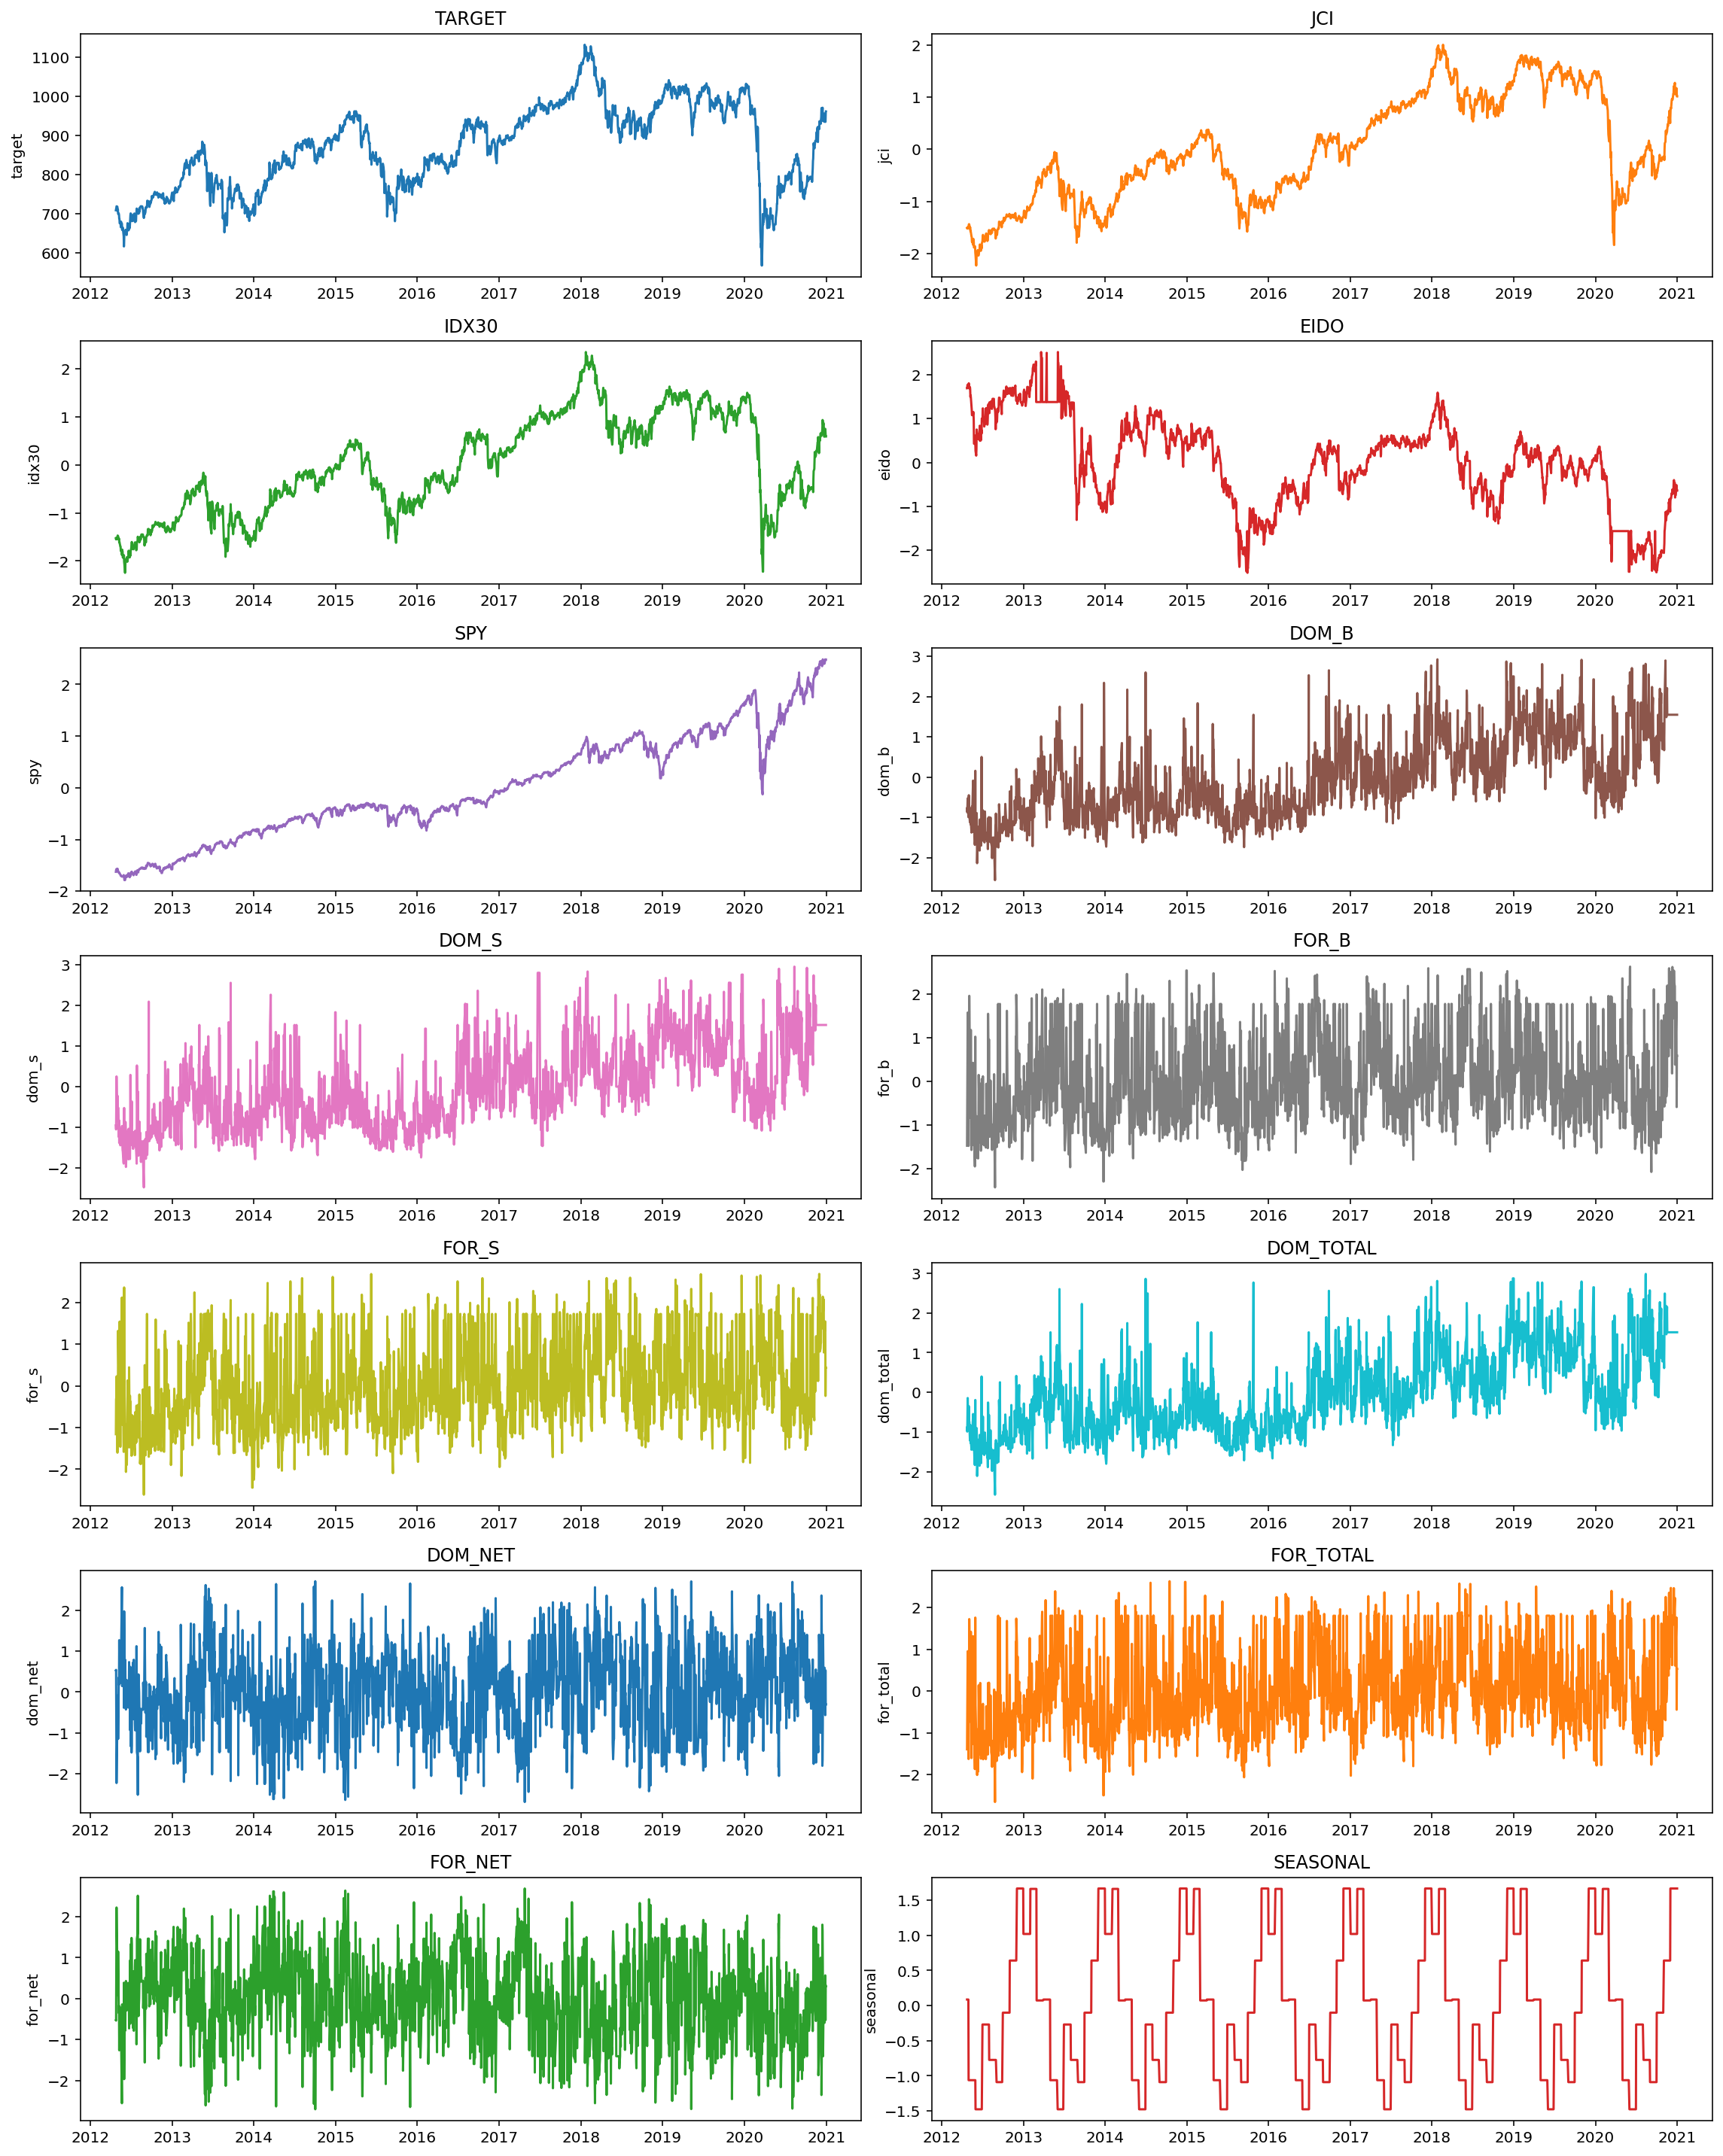

In [5]:
fname = models_dir + 'sarimax_nostat.pkl'
model = gf.load_from_pkl(filename=fname)

fname = data_remod_dir + 'scaler_x_nostat.pkl'
scaler = gf.load_from_pkl(filename=fname)

Predictor = predict.Predictor(model=model, scaler=scaler)

df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_ready_for_modelling.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_ready_for_modelling.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_ready_for_modelling.pkl')
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'

x_train = df_train.loc[:, ~df_train.columns.isin(['target'])].copy()
x_valid = df_valid.loc[:, ~df_valid.columns.isin(['target'])].copy()
x_test = df_test.loc[:, ~df_test.columns.isin(['target'])].copy()
y_train = df_train['target'].values
y_valid = df_valid['target'].values
y_test = df_test['target'].values

df_forecast_train = Predictor.forecast_evaluation(x_dataframe=x_train, y_data=y_train, name='pred_train')
df_forecast_valid = Predictor.forecast_evaluation(x_dataframe=x_valid, y_data=y_valid, name='pred_valid')
df_forecast_test = Predictor.forecast_evaluation(x_dataframe=x_test, y_data=y_test, name='pred_test')

gf.plotting_line_all(dataframe=df_train)

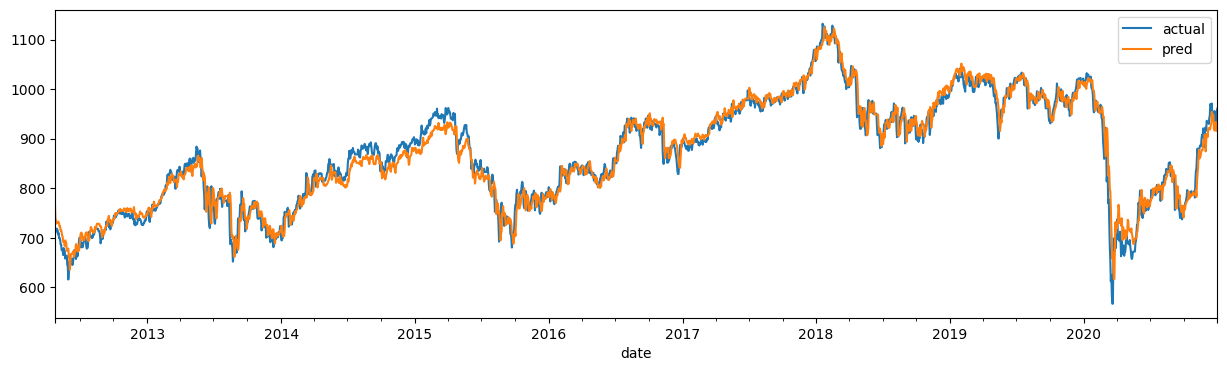

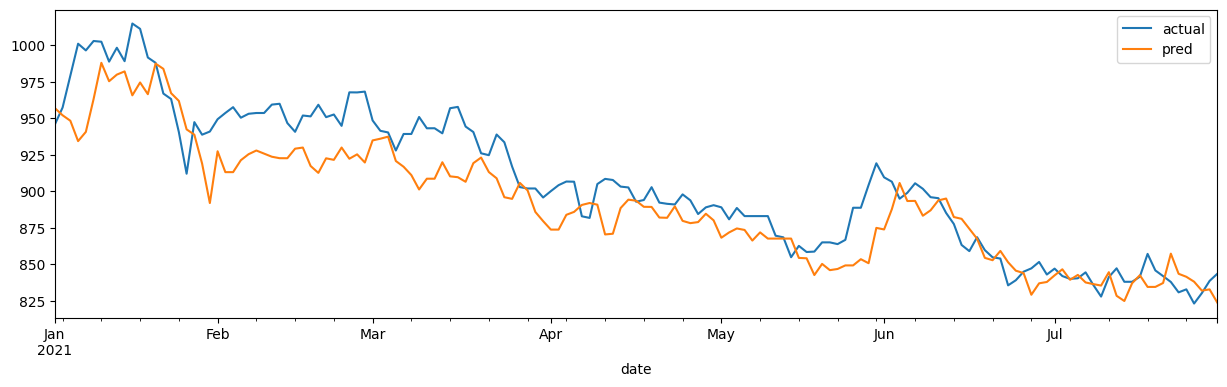

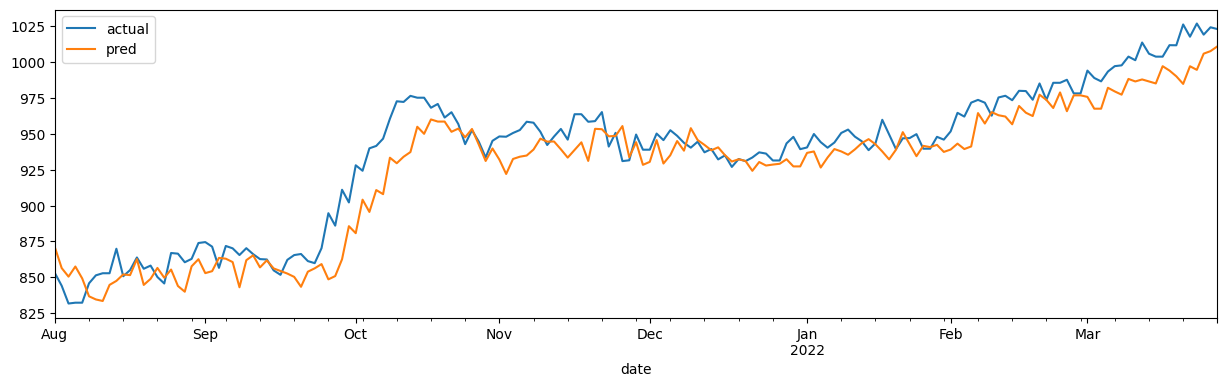

In [6]:
df_forecast_train.plot(figsize =(15,4))
df_forecast_valid.plot(figsize =(15,4))
df_forecast_test.plot(figsize =(15,4))
plt.show()

## Stationary, target tidak STDZ

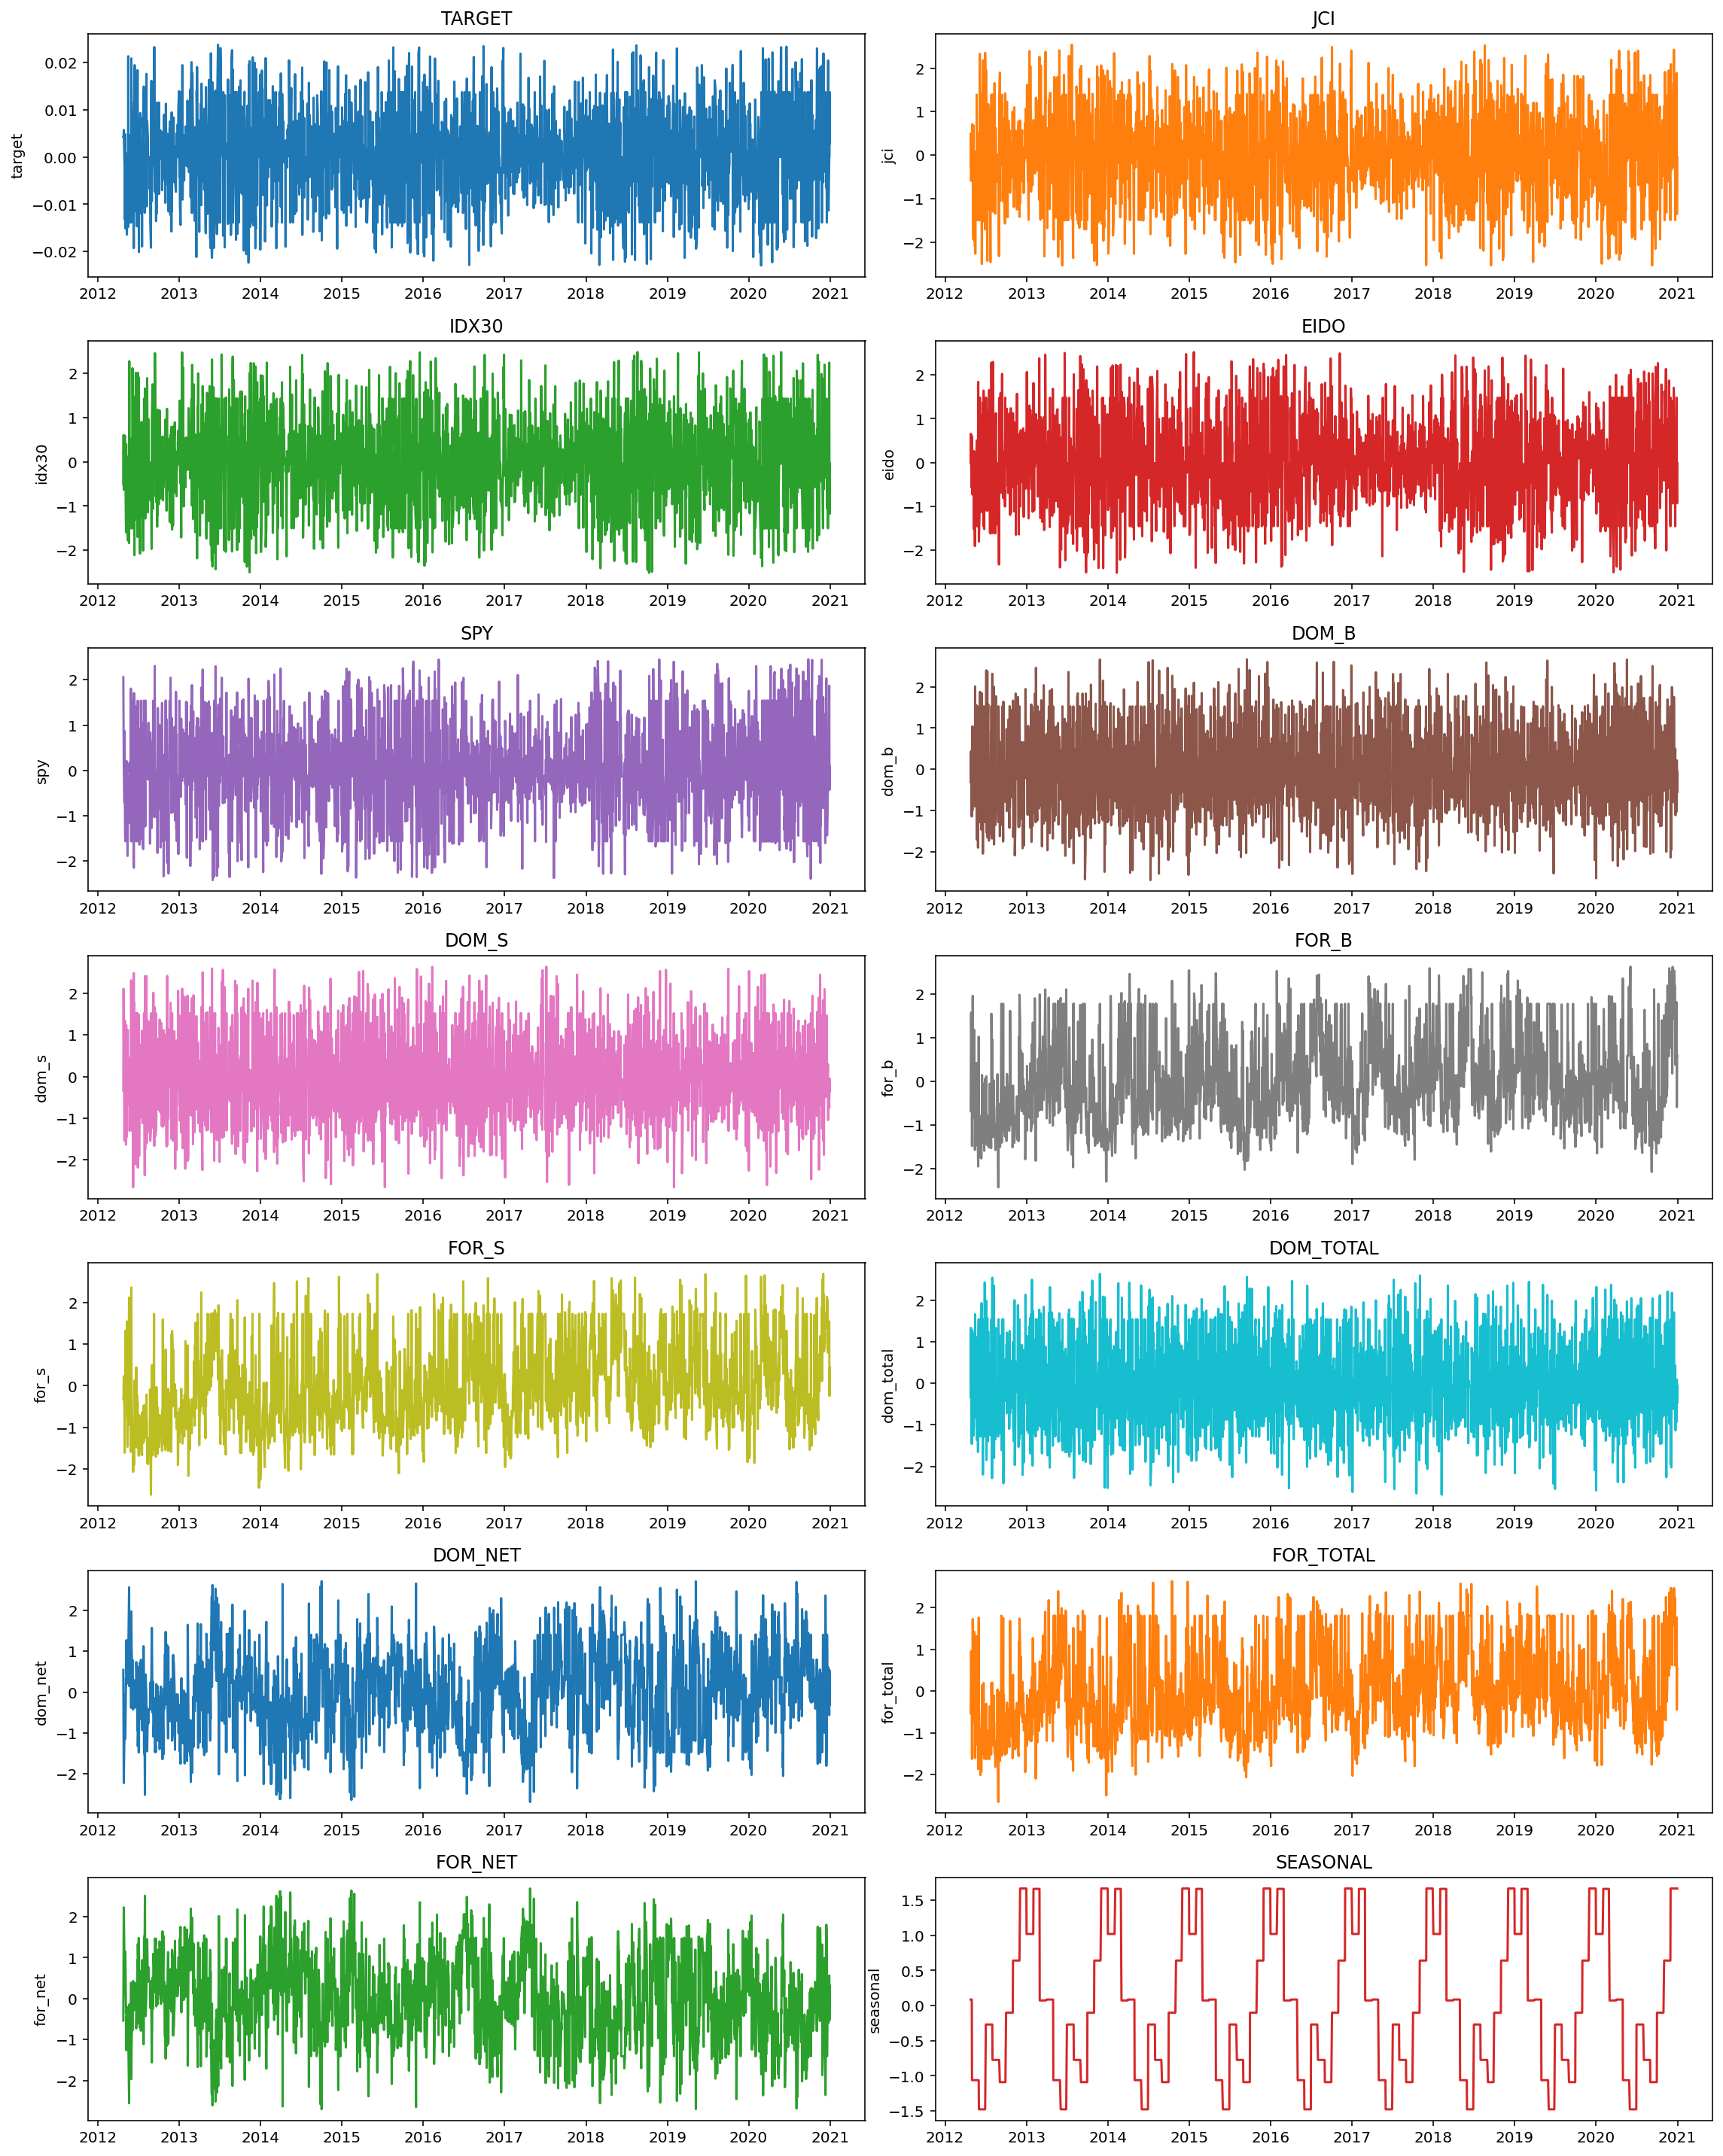

In [7]:
fname = models_dir + 'sarimax_stat.pkl'
model = gf.load_from_pkl(filename=fname)

fname = data_remod_dir + 'scaler_x_stat.pkl'
scaler = gf.load_from_pkl(filename=fname)

Predictor = predict.Predictor(model=model, scaler=scaler)
df_train = gf.load_from_pkl(f'{data_proc_dir}df_train_ready_for_modelling_stat.pkl')
df_valid = gf.load_from_pkl(f'{data_proc_dir}df_valid_ready_for_modelling_stat.pkl')
df_test = gf.load_from_pkl(f'{data_proc_dir}df_test_ready_for_modelling_stat.pkl')
df_train.name, df_valid.name, df_test.name = 'DATA TRAIN','DATA VALID','DATA TEST'

x_train = df_train.loc[:, ~df_train.columns.isin(['target'])].copy()
x_valid = df_valid.loc[:, ~df_valid.columns.isin(['target'])].copy()
x_test = df_test.loc[:, ~df_test.columns.isin(['target'])].copy()
y_train = df_train['target'].values
y_valid = df_valid['target'].values
y_test = df_test['target'].values

df_forecast_train = Predictor.forecast_evaluation(x_dataframe=x_train, y_data=y_train, name='pred_train')
df_forecast_valid = Predictor.forecast_evaluation(x_dataframe=x_valid, y_data=y_valid, name='pred_valid')
df_forecast_test = Predictor.forecast_evaluation(x_dataframe=x_test, y_data=y_test, name='pred_test')

gf.plotting_line_all(dataframe=df_train)

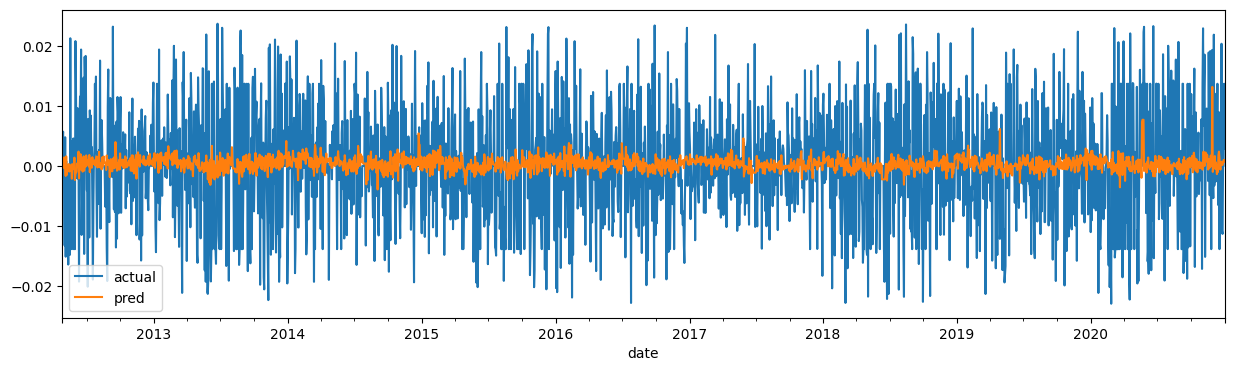

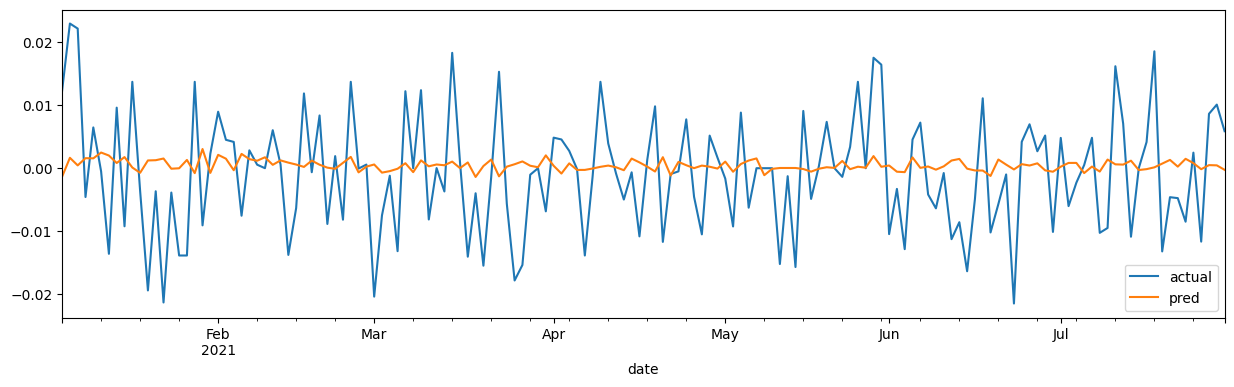

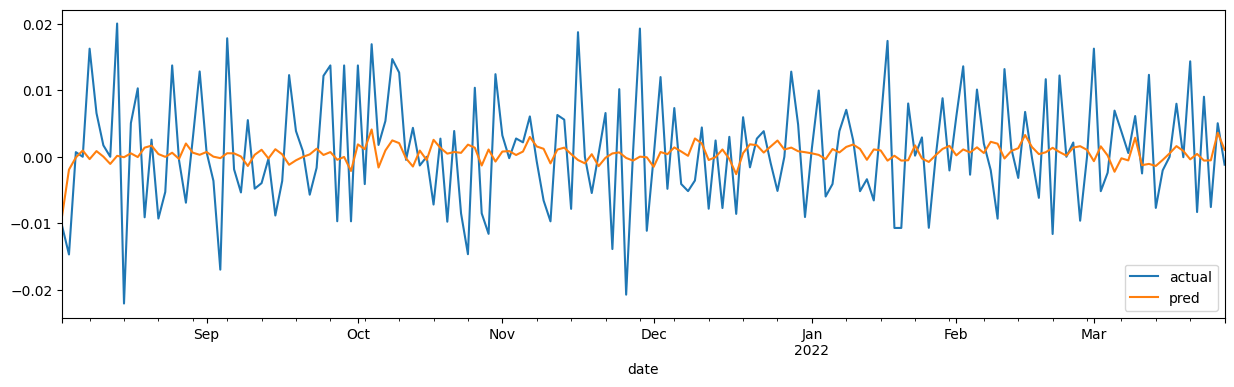

In [8]:
df_forecast_train.plot(figsize =(15,4))
df_forecast_valid.plot(figsize =(15,4))
df_forecast_test.plot(figsize =(15,4))
plt.show()

# Evaluation #2

## Predict Real

In [2]:
fname = models_dir + gf.read_config(config_dir=config_dir, section='FILENAME', key='MODEL') + '.pkl'
model = gf.load_from_pkl(filename=fname)

fname = data_remod_dir + gf.read_config(config_dir=config_dir, section='FILENAME', key='SCALER') + '.pkl'
scaler = gf.load_from_pkl(filename=fname)

Predictor = predict.Predictor(model=model, scaler=scaler)

In [3]:
actual_list = []
pred_list = []
for i in range(1,11):
    i_to = -1 * i
    i_from = i_to - 1
    df_real = gf.load_from_pkl(filename=f'{data_proc_dir}df_test_ready_for_modelling.pkl')[i_from:i_to]
    X_real = df_real.loc[:, ~df_real.columns.isin(['target'])].copy()

    actual_list.append(df_real.target.values[0])
    pred_list.append(Predictor.get_pred_value(dataframe=X_real)[0])
    print(i,
          f'{actual_list[i-1]:.2f}', 
          f'{pred_list[i-1]:.2f}',
          sep=' | ')


1 | 1024.22 | 1050.36
2 | 1019.08 | 1048.60
3 | 1026.84 | 1037.32
4 | 1017.67 | 1039.82
5 | 1026.19 | 1027.52
6 | 1011.68 | 1032.82
7 | 1011.75 | 1036.83
8 | 1003.76 | 1039.86
9 | 1003.77 | 1027.84
10 | 1005.82 | 1029.20
